
# Projet: Facebook BaBi tasks
Notebook de la semaine du 22/03
Par Thierry Loesch et Bryce Tichit

Dernier notebook

Comme demandé par notre tuteur, nous allons désormais essayer d'adapter les travaux fait jusqu'ici sur un autre projet sensiblement identique.

-----------------------------------

5.1  Notation automatique de réponses courtes à des questions

Les données sont ici pour le téléchargement et leur description est dans cet article

Lorsque l'on connait:

    une question,
    une réponse d'un étudiant,
    la bonne réponse, 

comment prédire la note à donné à la réponse de l'étudiant. Il peut être aussi intéressant d'essayer d'apprendre à générer la réponse. 

--------------------------

On cherchera en premier à prédire la note de l'étudiant, le réseau devra rendre un réel. Normaliser les notes (les mettre entre 0 et 1) et activation par Sigmoid (output entre 0 et 1) afin de prédire la note.

In [7]:
import re
from keras.utils.data_utils import get_file
import zipfile
import string

def tokenize(sent):
    
    def remPunctuation(sent):
        return "".join(l for l in sent if l not in string.punctuation)
        
    return [x.strip() for x in re.split('(\W+)?', remPunctuation(sent.lower())) if x.strip()]

def parseData(questions,answers,student_answers=''):
    
    #questions_data = dict() #ce dictionnaire contiendra les tuples (question,answer) indexés par la clé "numéro de question"
    
    questions_data = dict()
    
    for line in questions.split('\n'): #une ligne = une question
        line = line.decode('utf-8').strip()
        try:
            index,question = line.split(' ',1)
        except:
            continue
        
        questions_data[index] = [question.replace('<STOP>',''),None]
    
    for line in answers.split('\n'):
        line = line.decode('utf-8').strip()
        
        try:
            index,answer = line.split(' ',1)
        except:
            continue
            
        questions_data[index][1] = answer.replace('<STOP>','')
        
    questions_data = {k: tuple(map(tokenize,v)) for k, v in questions_data.items()}
    
    stud_ans = dict()
    
    for line in student_answers.split('\n'):
        line = line.decode('utf-8')
        try:
            index,ans = line.split(' ',1)
        except:
            continue
            
        answers=ans.split('<STOP>')
        answers=[a for a in answers if a]
            
        if index in stud_ans:
            stud_ans[index] += map(tokenize,answers)
        else:
            stud_ans[index] = map(tokenize,answers)
    
    return questions_data,stud_ans
        
    
def parseIntoExamples(qd,sa):
    
    ret = list()
    
    for index,q_a in qd.items():
        scores = [k for k in archive.read('data/scores/'+str(index+'/ave')).split('\n') if k]
        for stud_ans,score in zip(sa[index],scores):
            ret.append((q_a[0],q_a[1],stud_ans,float(score)/5.))
    return ret
                       


    

In [8]:
try:
    path = get_file('shortAnswerGrading-v-2-0.zip',origin='http://web.eecs.umich.edu/~mihalcea/downloads/ShortAnswerGrading_v2.0.zip')
except:
    print "error while downloading file"
    
    
archive = zipfile.ZipFile(path,'r')
    
questions = archive.read('data/sent/questions') 
answers = archive.read('data/sent/answers')
student_answers = archive.read('data/sent/all') 

dic1,dic2 = parseData(questions,answers,student_answers)


data = parseIntoExamples(dic1,dic2)

nbSamples = len(data)

data_train = data[0:nbSamples/2]
data_test = data[(nbSamples/2):-1]

#print data[0]

vocab = set()
for (a,b,c,_) in data:
    for x in [a,b,c]:
        vocab.update(x)
vocab=sorted(list(vocab))

print len(vocab)

vocab_size = len(vocab) +1
word_idx = dict((c,i+1) for i,c in enumerate(vocab))
question_maxsize = max((len(x) for x,_,_,_ in data))
answer_stud_maxsize = max(len(x) for _,_,x,_ in data)
answer_maxsize = max((len(x) for _,x,_,_ in data))

vocab[0:300]

            
            


2223


[u'0',
 u'000000',
 u'012',
 u'0x',
 u'1',
 u'10',
 u'115',
 u'12345',
 u'123456789',
 u'124',
 u'154',
 u'18',
 u'1each',
 u'1long',
 u'1st',
 u'2',
 u'20',
 u'256',
 u'2nd',
 u'2the',
 u'3',
 u'35',
 u'3n',
 u'4',
 u'40',
 u'400',
 u'5',
 u'5555',
 u'5657',
 u'6',
 u'68',
 u'7',
 u'72',
 u'8',
 u'80',
 u'88123',
 u'8th',
 u'a',
 u'ability',
 u'able',
 u'about',
 u'above',
 u'abstract',
 u'abstraction',
 u'accepted',
 u'accepts',
 u'accesed',
 u'access',
 u'accessed',
 u'accessible',
 u'accessing',
 u'accessmodifier',
 u'accessspecifications',
 u'accessspecifiers',
 u'accomplish',
 u'according',
 u'accordingly',
 u'account',
 u'accurate',
 u'achieved',
 u'acknowledged',
 u'acordingly',
 u'across',
 u'act',
 u'acted',
 u'actions',
 u'activity',
 u'actual',
 u'actually',
 u'ad',
 u'add',
 u'added',
 u'adding',
 u'addition',
 u'additional',
 u'address',
 u'addressed',
 u'addresses',
 u'adds',
 u'adjacent',
 u'adjust',
 u'adjusted',
 u'adt',
 u'advance',
 u'advantage',
 u'advantages',
 u'

A faire:
- Nettoyer le vocabulaire pour diminuer sa taille, synonymes, lowercase

Pour cela on peut utiliser NTLK et les Stemmer, afin de réduire significativement la taille du vocabulaire, également voir ce  qu'on peut faire pour les nombres. Les associer à un unique mot?


In [23]:
#Mettons tout ça dans des matrices
from keras.preprocessing.sequence import pad_sequences
import numpy as np

#précision de 50% avec question , stud_answer , score

def vectorize(data,wordidx,qmaxlen,amaxlen):
    X,Xs,Y = list(),list(),list()
    
    lookup = lambda m : wordidx[m]
    
    for question, ans , student_answer, score in data:
        X.append(map(lookup,ans))
        Xs.append(map(lookup,student_answer))
        Y.append(score)
        
    return pad_sequences(X, maxlen=qmaxlen), pad_sequences(Xs, maxlen=amaxlen), np.array(Y)
        
    
X,Xq,Y = vectorize(data_train,word_idx,answer_maxsize,answer_stud_maxsize)
X_test,Xq_test,Y_test = vectorize(data_test,word_idx,answer_maxsize,answer_stud_maxsize)
#X_test,Xq_test,Y_test = vectorize(test,word_idx,story_max,question_max)
#X_val,Xq_val,Y_val = vectorize(validation,word_idx,story_max,question_max)

In [17]:
print X[0:10]
print Xq[0:10]
print Y[0:10]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 2018   76 1333 2018 1162  949 1230 2181
  2018  832  337 1695]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 2018   76 1333 2018 1162  949 1230 2181
  2018  832  337 1695]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  

# Modele

Il s'agit du même modèle que pour les babi-tasks mais legèrement modifié, voir ce qu'on peut tenter comme modèle (question? answer? stud_answer?) mais à priori garder la même architecture.

Actuellement les performances sont faibles à cause de la taille du vocabulaire (embed_size trop petit pour sa taille) il faut augmenter l'embed_size de manière raisonnable mais aussi diminuer la taille du vocabulaire

In [38]:
#Model

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Merge,RepeatVector,Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam


embed_size = 100
batch_size=256
epochs=10

question_model = Sequential()
question_model.add(Embedding(vocab_size,embed_size,input_length=answer_maxsize))
question_model.add(LSTM(embed_size))

ans_model = Sequential()
ans_model.add(Embedding(vocab_size,embed_size,input_length=answer_stud_maxsize))
ans_model.add(LSTM(embed_size))
#ans_model.add(RepeatVector(answer_maxsize)) #permet d'ajuster la taille du modèle afin de préparer un merge


model = Sequential()
model.add(Merge([question_model, ans_model], mode='concat',concat_axis=1))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(optimizer=Adam(lr=0.01),loss='mse',metrics=['accuracy'])

model.summary()

history = model.fit([X, Xq], Y, batch_size=batch_size, nb_epoch=epochs)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_34 (Embedding)         (None, 53, 100)       222400                                       
____________________________________________________________________________________________________
lstm_26 (LSTM)                   (None, 100)           80400                                        
____________________________________________________________________________________________________
embedding_35 (Embedding)         (None, 74, 100)       222400                                       
____________________________________________________________________________________________________
lstm_27 (LSTM)                   (None, 100)           80400                                        
___________________________________________________________________________________________

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotLearningCurves_acc(history_model,save=''):
    plt.plot(history_model.history['acc'])
    plt.plot(history_model.history['val_acc'])
    plt.title('Precision du modele')
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()
    
def plotLearningCurves_loss(history_model,save=''):
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Perte sur le modele')
    plt.ylabel('Perte')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()

1220/1220 [==============================] - 9s     

Perte = 0.067
Précision = 50%


KeyError: 'val_acc'

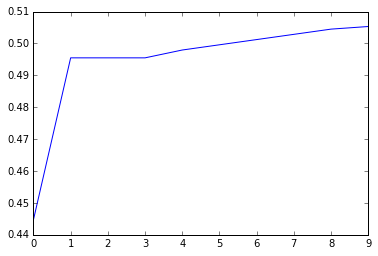

In [39]:
#Calcul de précision sur l'ensemble de test

loss,acc = model.evaluate([X_test,Xq_test],Y_test, batch_size=batch_size)
print "\nPerte = {:.3f}".format(loss)
print "Précision = {:.0f}%".format(acc*100)

plotLearningCurves_acc(history)

plotLearningCurves_loss(history)